# Import

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Data


In [2]:
satelit_data=(r'..\data\AgERA5_4params_graz.csv')
local_data=(r'..\data\new_5sta(DNOWS)_3com(NO2,PM10K,O3)_year2010_TemporalDummies_Ox_holidays_meteo.csv')
traffic_data=(r'..\data\traffic_KP.xlsx')

In [3]:
df_satelit= pd.read_csv(satelit_data,index_col = 0)
df_local = pd.read_csv(local_data,index_col = 0)

In [4]:
df_local.index = pd.to_datetime(df_local.index)
df_local.columns
df_local.Ost_Winddirection

2010-01-01          NaN
2010-01-02          NaN
2010-01-03          NaN
2010-01-04          NaN
2010-01-05          NaN
                ...    
2021-07-03    182.59240
2021-07-04    130.74823
2021-07-05    139.74475
2021-07-06    129.45146
2021-07-07    130.95103
Name: Ost_Winddirection, Length: 4206, dtype: float64

In [5]:
df_satelit.index = pd.to_datetime(df_satelit.index)

In [6]:
df_ulice = pd.read_excel(traffic_data, engine='openpyxl', sheet_name='Sheet1', index_col=0)
df_ulice_podaci = pd.read_excel(traffic_data, engine='openpyxl', sheet_name='traffic_data_containsNA_KP', index_col=0)

In [7]:
df_ulice_podaci.index = pd.to_datetime(df_ulice_podaci.index)

In [8]:
df_local=df_local['2018-01-01':'2020-03-15']
df_ulice_podaci=df_ulice_podaci['2018-01-01':'2020-03-15']
df_satelit=df_satelit['2018-01-01':'2020-03-15']

# Nan values

In [9]:
print(df_local.isnull().sum()) 
print(df_satelit.isnull().sum())

print(df_ulice_podaci.isnull().sum())
df_local = df_local.fillna(df_local.mean())
df_ulice_podaci = df_ulice_podaci.fillna(method='bfill')
df_ulice_podaci = df_ulice_podaci.fillna(df_ulice_podaci.mean())

D_NO2                0
D_PM10K              0
N_NO2                0
N_O3                 0
N_PM10K              0
                    ..
Ost_Pressure         0
Ost_RH               1
Ost_Temp             0
Ost_Winddirection    0
Ost_Windspeed        0
Length: 62, dtype: int64
Cloud_Cover_Mean                     0
Temperature_Air_2m_Max_Day_Time      0
Temperature_Air_2m_Min_Night_Time    0
Wind_Speed_10m_Mean                  0
dtype: int64
8010_208      2
8020_110      2
8020_119      3
8020_122      2
8053_111      2
8010_205      2
8010_209      2
8010_213      2
8010_214      2
8020_102      5
8020_103      2
8020_107     45
8041_218      2
8041_221      2
8045_203    155
8051_101      2
dtype: int64


# Merge

In [10]:
Postaje=df_ulice.Reference_station
Udaljenost = df_ulice['Distance to ref']

In [11]:

Postaje=df_ulice.Reference_station
for value,index,udaljenost in zip(Postaje,Postaje.index,Udaljenost):
    if value == 'Ost':
        print(value,index,udaljenost)

Ost 8010_208 2689.680221
Ost 8010_209 2017.9953620000001
Ost 8010_213 1828.992486
Ost 8010_214 1497.288645
Ost 8041_221 1855.044783


In [12]:
df_ulica_sve_O=df_ulice_podaci[['8010_208','8010_209','8010_213', '8010_214','8041_221']]

In [13]:
temporals = ['year', 'dayofyear', 'month_Apr',
       'month_Aug', 'month_Dec', 'month_Feb', 'month_Jan', 'month_Jul',
       'month_Jun', 'month_Mar', 'month_May', 'month_Nov', 'month_Oct',
       'month_Sep', 'weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'season_fall', 'season_spring', 'season_summer',
       'season_winter','holiday', 'holiday_school' ]
data_temporals = df_local[temporals]

In [14]:
data = pd.concat([df_ulica_sve_O, df_satelit],axis = 1, join='inner')


In [15]:
df = df_local.filter(regex='Ost')

In [16]:
data_2 =  pd.concat([data, df],axis = 1, join='inner')


In [17]:
data_3 =  pd.concat([data_2, data_temporals],axis = 1, join='inner')


# Priprema podataka i pretvaranje u tenzore

In [18]:
Y = df_local['O_NO2']
X = data_3
X_train = X['2018-01-01':'2019-12-31']
X_test = X['2020-01-03':'2020-03-15']
Y_train = Y['2018-01-01':'2019-12-31'].values.reshape((-1, 1))
Y_test = Y['2020-01-03':'2020-03-15'].values.reshape((-1, 1))

In [19]:
sc = MinMaxScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [20]:
X_train_t = torch.FloatTensor(X_train)
Y_train_t = torch.FloatTensor(Y_train).reshape(-1,1)

# Model

In [35]:
# Define network dimensions
input_size = X_train.shape[1]
# Layer size
hidden_size = 1000 # Number of hidden nodes
output_size = 1 # Number of output nodes for prediction
torch_model = torch.nn.Sequential(torch.nn.Linear(input_size, hidden_size),
                                  torch.nn.ReLU(),
                                  torch.nn.Linear(hidden_size, output_size))    

In [36]:
loss_func = torch.nn.MSELoss() #mean square error as loss metric
learning_rate = 0.001
optimizer = torch.optim.Adam(torch_model.parameters(), lr=learning_rate)

Text(0.5, 1.0, 'Training Loss')

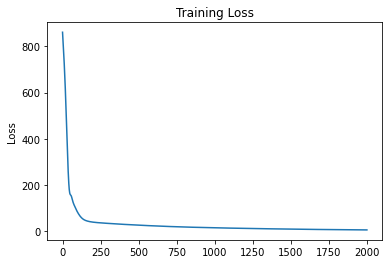

In [37]:
train_error = []
epochs = 2000

#Y_train_t = torch.FloatTensor(y_train).reshape(-1,1) #Converting numpy array to torch tensor

for e in range(epochs):
    #X_train_t = torch.FloatTensor(xtrain)  #Converting numpy array to torch tensor
    
    y_pred = torch_model(X_train_t)
    loss = loss_func(y_pred, Y_train_t)
    loss.backward()
    optimizer.step()
    
    optimizer.zero_grad()

    train_error.append(loss.item())

plt.plot(train_error)
plt.ylabel('Loss')
plt.title('Training Loss')

In [38]:
X_test_t = torch.FloatTensor(X_test)

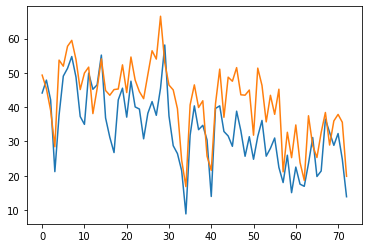

In [39]:
ypredict = torch_model(X_test_t)
# Descale
ypredict_np = ypredict.detach().numpy()
#ypredict_inverse = scaler_y.inverse_transform(ypredict_np)
#ytest_inverse = scaler_y.inverse_transform(ytest)

plt.plot(Y_test)#_inverse)
plt.plot(ypredict_np)#_inverse)

In [1]:
print('MSE:', mean_squared_error(Y_test, ypredict_np, squared=True))
print('R2:', r2_score(Y_test, ypredict_np))

NameError: name 'mean_squared_error' is not defined